<a href="https://colab.research.google.com/github/JumanaWanass/Sentiment-Classification-NLP-Task/blob/main/Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sentiment Classification using SST dataset

Our objective is to perform text classification into five distinct classes using the Stanford Sentiment Treebank (SST) dataset. The task involves employing two different classification approaches: Naive Bayes and Logistic Regression. Additionally, there is a third part dedicated to evaluation, where we will generate a confusion matrix and derive performance metrics from it.

##1. Data Preprocessing

The first step is to import all the necessary libraries, then study the dataset. Visualising the dataset will help us implement our custom algorithms and provide us with insights about its distribution

In [ ]:
!pip install datasets

from datasets import load_dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Load the SST dataset
sst_dataset = load_dataset("sst" , trust_remote_code=True)
train_df = pd.DataFrame(sst_dataset["train"])
validation_df = pd.DataFrame(sst_dataset["validation"])
test_df = pd.DataFrame(sst_dataset["test"])

In [ ]:
train_df.head()

,sentence,label,tokens,tree
0,The Rock is destined to be the 21st Century 's...,0.69444,The|Rock|is|destined|to|be|the|21st|Century|'s...,70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...
1,The gorgeously elaborate continuation of `` Th...,0.83333,The|gorgeously|elaborate|continuation|of|``|Th...,71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...
2,Singer\/composer Bryan Adams contributes a sle...,0.62500,Singer\/composer|Bryan|Adams|contributes|a|sle...,72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...
3,You 'd think by now America would have had eno...,0.50000,You|'d|think|by|now|America|would|have|had|eno...,36|35|34|33|33|32|30|29|27|26|25|24|23|23|22|2...
4,Yet the act is still charming here .,0.72222,Yet|the|act|is|still|charming|here|.,15|13|13|10|9|9|11|12|10|11|12|14|14|15|0


Then we remove the columns we don't need: Tree and tokens

In [ ]:
train_df.drop(['tree', 'tokens'], axis = 1 ,inplace=True)
validation_df.drop(['tree', 'tokens'], axis = 1, inplace=True)
test_df.drop(['tree', 'tokens'], axis = 1, inplace=True)

In [ ]:
train_df.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,0.69444
1,The gorgeously elaborate continuation of `` Th...,0.83333
2,Singer\/composer Bryan Adams contributes a sle...,0.62500
3,You 'd think by now America would have had eno...,0.50000
4,Yet the act is still charming here .,0.72222


Next we categorise our labels using the following map:

•         From 0 to 0.2 (0.2 included) will be class 0 “very negative”.

•         From 0.2 to 0.4 (0.4 included) will be class 1 “negative”.

•         From 0.4 to 0.6 (0.6 included) will be class 2 “neutral”.

•         From 0.6 to 0.8 (0.8 included) will be class 3 “positive”.

•         From 0.8 to 1.0 (1.0 included) will be class 4 “very positive”.

In [ ]:
def map_values(value):
    if 0 <= value <= 0.2:
        return 0
    elif 0.2 < value <= 0.4:
        return 1
    elif 0.4 < value <= 0.6:
        return 2
    elif 0.6 < value <= 0.8:
        return 3
    else:
        return 4

In [ ]:
train_df['label'] = train_df['label'].apply(map_values)
validation_df['label'] = validation_df['label'].apply(map_values)
test_df['label'] = test_df['label'].apply(map_values)
train_df.describe()

,label
count,8544.000000
mean,2.058052
std,1.281570
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [ ]:
train_df.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer\/composer Bryan Adams contributes a sle...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


Next we visualise our dataset after applying our map:

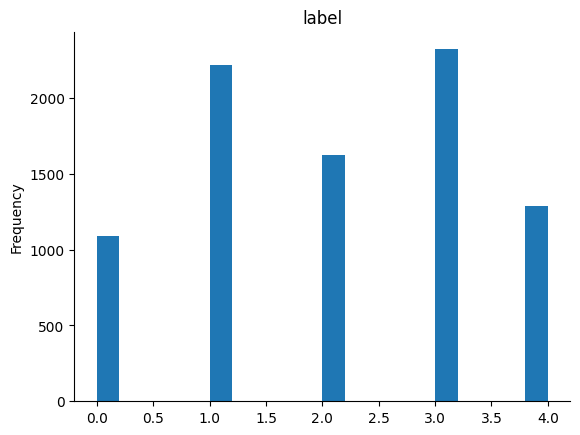

In [ ]:
train_df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

## 2. Naive Bayes

Now we will be using Naive Bayes for classification tasks. We will create our own Naive Bayes model and compare it with Sklearn's implementation.

### 2.1 Making our Naive Bayes model


Naive Bayes is a popular classification algorithm based on Bayes' theorem with the **assumption of independence between features**. In this section, we describe the process of building our own Naive Bayes classifier using only Numpy.

Naive Bayes Model Building Process:
1. Obtain class log priors and classes:
We start by calculating the log priors for each class and obtaining the unique classes present in the dataset.
2. Extract vocabulary:
Next, we extract the vocabulary of words from the training dataset.
3. Compute log likelihoods:
We calculate the log likelihoods of each word in the vocabulary for each class.
4. Train Naive Bayes model:
Finally, we combine the computed parameters to train our Naive Bayes classifier.


First we will need some helper functions for our Naive Bayes model

$\textbf{Description of Helper Functions:}$

$1.  \texttt{get_classes_logprior(train_df)}$: This function computes the class log priors and returns the unique classes present in the training dataset. The equation for calculating the class log prior: $\log(P(C_k))$ is given by:

$$\log(P(C_k)) = \log\left(\frac{{\text{Number of samples belonging to class $k$ } }}{{\text{Total number of samples}}}\right)$$

This function is essential for initializing the Naive Bayes classifier and obtaining the class log priors necessary for classification.

In [ ]:
def get_classes_logprior(train_df):
  classes = sorted(train_df['label'].unique())
  class_counts = train_df['label'].value_counts().sort_index()
  total_samples = train_df.shape[0]
  # Calculate log prior for each class using vectorized operations
  logprior = np.log(class_counts / total_samples)
  # Create a dictionary to store log prior for each class
  classes_logprior = dict(zip(class_counts.index, logprior))
  print("Log probability of each class:", classes_logprior)
  print("Out of get_classes_logprior")
  return classes_logprior, classes



$2. \texttt{get_vocabulary(train_df)}$: This function extracts the vocabulary of words from the training dataset.


In [ ]:
def get_vocabulary(train_df):
  vocabulary = set()
  for sentence in train_df['sentence']:
      vocabulary.update(sentence.split())
  print("Out of get_vocabulary")
  return sorted(vocabulary)

$3. \texttt{get_loglikelihood(train_df, classes, vocabulary)}$: The loglikelihood $ \log P(w|c) $ is calculated using Laplace smoothing to handle unseen words. For each word $ w $ in the vocabulary $ V $, we count the number of occurrences of $ w $ in documents belonging to class $ c $, denoted as $ \text{count}(w,c) $.

The Laplace smoothed probability of observing word $ w $ given class $ c $ is then computed as:

$
\log P(w|c) = \log \left( \frac{\text{count}(w, c) + 1}{\sum_{w_0 \in V} (\text{count}(w, c) + 1)} \right)
$

where $ \sum_{w_0 \in V} (\text{count}(w, c) + 1) $ represents the total count of all words in the vocabulary plus one, ensuring that even unseen words are assigned a non-zero probability.


In [ ]:
def get_loglikelihood(train_df, classes, vocabulary):
    num_classes = len(classes)
    num_words = len(vocabulary)
    log_likelihoods = np.zeros((num_classes, num_words))
    total_words_in_class = np.zeros(num_classes)

    for i, cls in enumerate(classes):
        class_df = train_df[train_df['label'] == cls]
        class_words = ' '.join(class_df['sentence']).split()
        total_words_in_class[i] = len(class_words)
        word_counts = np.array([class_words.count(word) for word in vocabulary])
        log_likelihoods[i] = np.log((word_counts + 1) / (total_words_in_class[i] + num_words))

    return log_likelihoods, total_words_in_class


$4. \texttt{train_naive_bayes(train_df)}:$ This function orchestrates the entire process of building the Naive Bayes classifier by calling the helper functions and returns the necessary parameters for classification.


Training our model:

In [ ]:
def train_naive_bayes(train_df):
  classes_logprior, classes = get_classes_logprior(train_df)
  vocabulary = get_vocabulary(train_df)
  log_likelihoods, total_words_in_class = get_loglikelihood(train_df, classes, vocabulary)

  return classes_logprior, log_likelihoods, vocabulary, total_words_in_class


In [ ]:
classes_logprior, log_likelihoods, vocabulary, total_words_in_class = train_naive_bayes(train_df)

Log probability of each class: {0: -2.0572184048951256, 1: -1.3486233932896636, 2: -1.6603370404783528, 3: -1.3028003989421393, 4: -1.892138654535677}
Out of get_classes_logprior
Out of get_vocabulary


#### Testing our model

Helper functions to test our model

In [ ]:
def predict(sentence, classes_logprior, log_likelihoods, vocabulary, total_words_in_class):
    classes = list(classes_logprior.keys())  # Extracting classes from the keys of the dictionary
    scores = np.zeros(len(classes))

    for i, cls in enumerate(classes):
        log_prior = classes_logprior[cls]
        log_likelihood = get_log_likelihood_for_sentence(sentence, log_likelihoods[i], vocabulary)
        scores[i] = log_prior + log_likelihood

    predicted_index = np.argmax(scores)
    return classes[predicted_index]

In [ ]:
def get_log_likelihood_for_sentence(sentence, class_log_likelihood, vocabulary):
    words = sentence.split()
    total_log_likelihood = 0

    for word in words:
        if word in vocabulary:
            word_index = vocabulary.index(word)
            total_log_likelihood += class_log_likelihood[word_index]

    return total_log_likelihood

Testing our model

In [ ]:
def test_naive_bayes(test_df, classes_logprior, log_likelihoods, vocabulary, total_words_in_class):
    predictions = []
    for index, row in test_df.iterrows():
        sentence = row['sentence']
        predicted_label = predict(sentence, classes_logprior, log_likelihoods, vocabulary, total_words_in_class)
        predictions.append(predicted_label)
    return predictions


### 2.2 Scikit learn Naive Bayes

Now we use the built in Naive Bayes inside of the scikit learn's library

In [ ]:
def naive_bayes_sklearn(test_df):
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB(alpha=1.0))  # add 1 Laplacian smoothing
    ])

    pipeline.fit(train_df['sentence'], train_df['label'])     # Fit the pipeline to the training data
    # Predict labels for the test data
    predictions = pipeline.predict(test_df['sentence'])
    return predictions

## 3. Logistic Regression

### 3.1 Feature representation

In [ ]:
class Bigram():
  def __init__(self):
    self.BiDict = None
    self.BiList = None
  def build(self,text):
    self.BiList = [b for l in text for b in zip(l[0][:-1], l[0][1:])]
    self.BiDict = {}
    for i,obj in enumerate(self.BiList):
      self.BiDict[obj] = i
  def getIndex(self,bigram):
    return self.BiDict.get(bigram,None)
  def getBigram(self,idx):
    return self.BiList[idx]
  def getVector(self,tokens):
    vec = np.ndarray((1,len(self.BiList)),dtype='bool')
    bigrams = [b for b in zip(tokens[:-1], tokens[1:])]
    for gram in bigrams:
      vec[self.getIndex(gram)] = 1
    return vec
    # bigram count approximately 80,000

In [ ]:
bigram = Bigram()
sentences = train_df['sentence'].tolist()
bigram.build(sentences)

# Transform sentences into sparse vector representation
for sentence in sentences:
    tokens = sentence.split()
    sparse_vector = bigram.getVector(tokens)

### 3.2 Making our Logistic Regression model

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=50000, fit_intercept=True, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.bigram = None  # Initialize Bigram object

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, y_pred, y):
        return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)

        self.W = np.zeros(X.shape[1])

        for i in range(self.num_iterations):
            z = np.dot(X, self.W)
            y_pred = self.sigmoid(z)
            gradient = np.dot(X.T, (y_pred - y)) / y.size
            self.W -= self.learning_rate * gradient

            if self.verbose and i % 10000 == 0:
                loss = self.loss(y_pred, y)
                #print(f'loss: {loss} \t')
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
        return self.sigmoid(np.dot(X, self.W))

    def predict(self, X):
        return np.round(self.predict_prob(X))

    def transform_text_to_vectors(self, sentences):
        vectors = []
        for sentence in sentences:
            tokens = sentence.split()
            sparse_vector = self.bigram.getVector(tokens)
            vectors.append(sparse_vector)
        return np.vstack(vectors)


In [ ]:
def encode_labels(labels):
    unique_labels = np.unique(labels)
    label_dict = {label: i for i, label in enumerate(unique_labels)}
    return np.array([label_dict[label] for label in labels])

# Extract the labels from train_df
y_train = train_df['label'].values
y_train_encoded = encode_labels(y_train)


In [ ]:
model = LogisticRegression(learning_rate=0.01, num_iterations=50000, fit_intercept=True, verbose=True)
model.bigram = Bigram()

# Fit the Bigram object to your dataset
model.bigram.build(sentences)

# Transform sentences into sparse vector representations
X_train_sparse = model.transform_text_to_vectors(sentences)
model.fit(X_train_sparse, y_train_encoded)

<ipython-input-21-9e54be106874>:17: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-21-9e54be106874>:17: RuntimeWarning: invalid value encountered in multiply
  return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_sparse, y_train_encoded, test_size=0.2, random_state=42)

# Initialize logistic regression model
custom_LR_model = LogisticRegression(learning_rate=0.01, num_iterations=50000, fit_intercept=True, verbose=True)
custom_LR_model.fit(X_train, y_train)

# Predict labels for the testing data
y_pred_LR_custom = model.predict(X_test)
conf_matrix_LR_custom = confusion_matrix(y_test, y_pred_LR_custom, num_classes=5)
# Calculate accuracy
accuracy = np.mean(y_pred_LR_custom == y_test)
print("Accuracy:", accuracy)


<ipython-input-21-9e54be106874>:17: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-21-9e54be106874>:17: RuntimeWarning: invalid value encountered in multiply
  return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()


Accuracy: 0.2545348156816852


### 3.3 Logistic Regression with Scikit learn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
# Preprocess the text data
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Using word bi-grams
X_train_vectorized = vectorizer.fit_transform(train_df['sentence'])
X_test_vectorized = vectorizer.transform(test_df['sentence'])

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, train_df['label'])

# Predict labels for the test dataset
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
conf_matrix_LR = confusion_matrix(test_df['label'], y_pred, num_classes=5)
accuracy = accuracy_score(test_df['label'], y_pred)
precision = precision_score(test_df['label'], y_pred, average=None)
recall = recall_score(test_df['label'], y_pred, average=None)
f1 = f1_score(test_df['label'], y_pred, average=None)

# Print results
print("Confusion Matrix:")
print(conf_matrix_LR)
print("\nPrecision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)


Confusion Matrix:
[[ 36 136  41  58   8]
 [ 38 332  97 148  18]
 [ 18 152  57 142  20]
 [  4 142  49 274  41]
 [ 11  77  35 192  84]]

Precision: [0.3364486  0.39570918 0.20430108 0.33660934 0.49122807]
Recall: [0.12903226 0.52448657 0.14652956 0.5372549  0.21052632]
Accuracy: 0.35429864253393667
F1 Score: [0.1865285  0.45108696 0.17065868 0.41389728 0.29473684]


### 3.4 Logistic regression with SGD classifier

In [ ]:
X = train_df['sentence']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert continuous values to binary labels
y_train = (y_train >= 0.5).astype(int)
y_test = (y_test >= 0.5).astype(int)

# Create a pipeline with CountVectorizer and SGDClassifier
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(2, 2))),
    ('classifier', SGDClassifier(loss='log_loss', max_iter=1000))  # Use SGD with logistic regression
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.8782913984786425
              precision    recall  f1-score   support

           0       0.38      0.01      0.03       206
           1       0.88      1.00      0.94      1503

    accuracy                           0.88      1709
   macro avg       0.63      0.51      0.48      1709
weighted avg       0.82      0.88      0.83      1709



## 4. Evaluation Metrics

### 4.1 Confusion matrix function

In [ ]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)
    true_labels = np.asarray(true_labels, dtype=int)
    predicted_labels = np.asarray(predicted_labels, dtype=int)
    for i in range(len(true_labels)):
        conf_mat[true_labels[i], predicted_labels[i]] += 1
    return conf_mat


### 4.2 Precision, recall, F1

In [ ]:
def precision_recall_f1(true_labels, predicted_labels, num_classes):
    conf_mat = confusion_matrix(true_labels, predicted_labels, num_classes)
    num_classes = len(conf_mat)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    for i in range(num_classes):
        true_positives = conf_mat[i, i]
        false_positives = np.sum(conf_mat[:, i]) - true_positives
        false_negatives = np.sum(conf_mat[i, :]) - true_positives
        precision[i] = true_positives / (true_positives + false_positives)
        recall[i] = true_positives / (true_positives + false_negatives)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    return precision, recall, f1, macro_precision, macro_recall, macro_f1

### 4.3 Comparing the models:

#### Custom Naive Bayes vs Sklearn Niave bayes

In [ ]:
def compare_models(true_labels, predicted_labels_custom, predicted_labels_sklearn, num_classes):
    # Calculate evaluation metrics for custom model
    precision_custom, recall_custom, f1_custom, macro_precision_custom, macro_recall_custom, macro_f1_custom = precision_recall_f1(true_labels, predicted_labels_custom, num_classes)

    # Calculate evaluation metrics for sklearn model
    precision_sklearn, recall_sklearn, f1_sklearn, macro_precision_sklearn, macro_recall_sklearn, macro_f1_sklearn = precision_recall_f1(true_labels, predicted_labels_sklearn, num_classes)

    return (precision_custom, recall_custom, f1_custom, macro_precision_custom, macro_recall_custom, macro_f1_custom), (precision_sklearn, recall_sklearn, f1_sklearn, macro_precision_sklearn, macro_recall_sklearn, macro_f1_sklearn)

In [ ]:
true_labels = test_df['label']
predicted_labels_custom = test_naive_bayes(test_df, classes_logprior, log_likelihoods, vocabulary, total_words_in_class)
predicted_labels_sklearn = naive_bayes_sklearn(test_df)

num_classes = len(np.unique(true_labels))
metric_names = ['Precision', 'Recall', 'F1-Score', 'Macro Precision', 'Macro Recall', 'Macro F1']


In [ ]:
def plot_comparison_graph(metrics_custom, metrics_sklearn, metric_names):
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
    width = 0.35
    x = np.arange(len(metric_names))

    # Define colors for custom and sklearn models
    color_custom = 'blue'
    color_sklearn = 'red'

    for i, metric_name in enumerate(metric_names):
        ax.bar(x[i] - width/2, metrics_custom[i], width, label='Custom Naive Bayes', color=color_custom)
        ax.bar(x[i] + width/2, metrics_sklearn[i], width, label='Sklearn Naive Bayes', color=color_sklearn)

    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Naive Bayes Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names, rotation=45)  # Rotate x-axis labels for better readability
    ax.legend(['Custom Naive Bayes (Blue)', 'Sklearn Naive Bayes (Red)'], loc='upper left')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

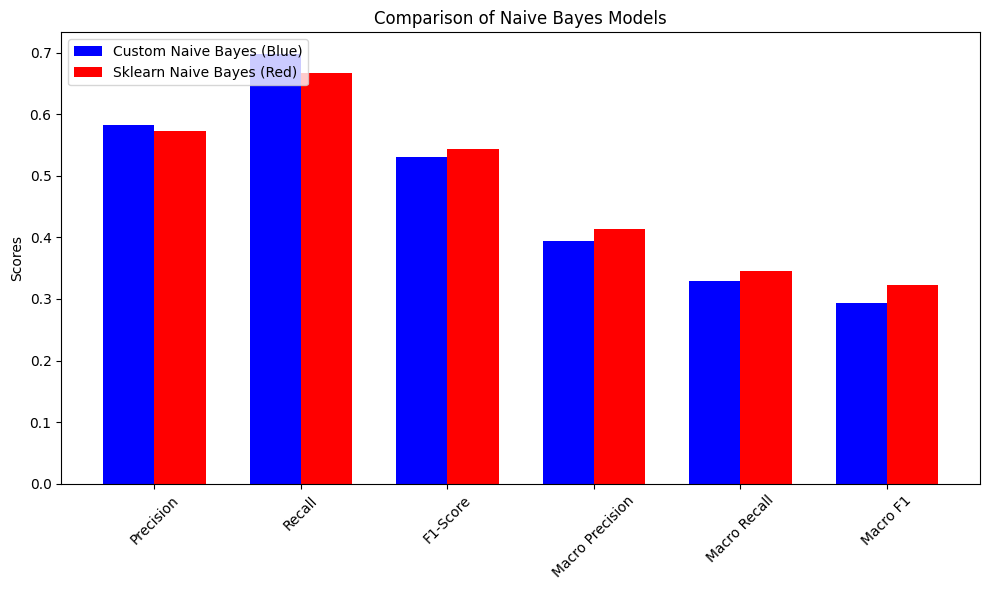

In [ ]:
custom_metrics, sklearn_metrics = compare_models(true_labels, predicted_labels_custom, predicted_labels_sklearn, num_classes)
plot_comparison_graph(custom_metrics, sklearn_metrics, metric_names)

#### Custom Logistic Regression vs Sklearn's LR

In [ ]:
print("Confusion matrix for Sklearn's LR:")
print(conf_matrix_LR)

Confusion matrix for Sklearn's LR:
[[ 36 136  41  58   8]
 [ 38 332  97 148  18]
 [ 18 152  57 142  20]
 [  4 142  49 274  41]
 [ 11  77  35 192  84]]


In [ ]:
print("Confusion matrix for custom LR:")
print(conf_matrix_LR_custom)

Confusion matrix for custom LR:
[[  0 206   0   0   0]
 [  0 435   0   0   0]
 [  0 322   0   0   0]
 [  0 488   0   0   0]
 [  0 258   0   0   0]]
